In [1]:
import numpy as np 
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from warnings import filterwarnings
from pandas.tseries.offsets import YearEnd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from tqdm import tqdm
from matplotlib import gridspec

filterwarnings('ignore')

# 데이터 로딩

In [60]:
df_ret  = pd.read_pickle('./DATA/real_ret.pkl').astype(float).resample('m').last()
df_eq   = pd.read_pickle('./DATA/BE.pkl').astype(float).resample('m').last()    
df_cap  = pd.read_pickle('./DATA/kospi_capital_tmp.pkl').astype(float).resample('m').last()
df_info = pd.read_pickle('./DATA/real_kospi_info.pkl')#.astype(float)
df_code = pd.read_pickle('./DATA/real_kospi_code.pkl')#.astype(float)

rf = pd.read_csv('./DATA/CD91.csv', index_col=0, parse_dates=True).apply(lambda x : x/100).resample('m').last()

#  필요 함수

In [61]:
def cal_mdd (ret_df):
    
    cum = ((ret_df+1).cumprod()-1)
    p = np.maximum.accumulate(cum)
    dd = (cum-p)/p
    return dd

# 데이터 전처리

In [62]:
'''시장, 업종 필터링'''
df_ret = df_ret * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
df_ret = df_ret * pd.DataFrame(np.where(df_code == 'K', 0, 1.0), index=df_code.index, columns=df_code.columns)

# df_eq = df_eq * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
# df_eq = df_eq * pd.DataFrame(np.where(df_code == 'K', 0, 1.0), index=df_code.index, columns=df_code.columns)

# df_cap = df_cap * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
# df_cap = df_cap * pd.DataFrame(np.where(df_code == 'K', 0, 1.0), index=df_code.index, columns=df_code.columns)

#mom_ret = df_ret.shift(1).rolling(11).apply(lambda x: (1+x).prod()-1)
monthly_ret = df_ret

# SMB, HML Port 생성

In [63]:
'''날짜 건들면 손모가지 날아가분다잉'''
time_idx = monthly_ret.loc['1996-03-01':].index

m_ret = monthly_ret.loc[time_idx]

In [64]:
'''날짜 건들면 손모가지 날아가분다잉'''
time_idx = monthly_ret.loc['1996-03-01':].index

m_ret = monthly_ret.loc[time_idx]

value_ratio = df_eq / df_cap.loc[:df_eq.index[-1]]
'''Cap의 중간'''
small = df_cap.apply(lambda x: x.replace(0, np.NaN).dropna()[x.replace(0, np.NaN).dropna()<x.replace(0, np.NaN).dropna().median()].index.to_list(), axis=1).dropna().loc[time_idx]
big = df_cap.apply(lambda x: x.replace(0, np.NaN).dropna()[x.replace(0, np.NaN).dropna()>=x.replace(0, np.NaN).dropna().median()].index.to_list(), axis=1).dropna().loc[time_idx]

'''가치는 equity/cap 한 것을 가지고 만듦'''
growth = value_ratio.apply(lambda x: x.replace(0, np.NaN).dropna()[x.replace(0, np.NaN).dropna()<x.replace(0, np.NaN).dropna().quantile(0.3)].index.to_list(), axis=1).dropna().loc[time_idx]
neutral = value_ratio.apply(lambda x: x.replace(0, np.NaN).dropna()[(x.replace(0, np.NaN).dropna()>=x.replace(0, np.NaN).dropna().quantile(0.3))& x.replace(0, np.NaN).dropna()<x.replace(0, np.NaN).dropna().quantile(0.7)].index.to_list(), axis=1).dropna().loc[time_idx]
value = value_ratio.apply(lambda x: x.replace(0, np.NaN).dropna()[x.replace(0, np.NaN).dropna()>=x.replace(0, np.NaN).dropna().quantile(0.7)].index.to_list(), axis=1).dropna().loc[time_idx]

<AxesSubplot:>

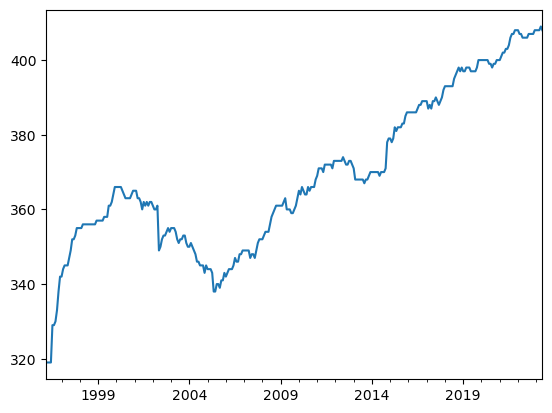

In [66]:
pd.DataFrame(small).apply(lambda x: len(x[0]), axis=1).plot()

In [79]:
SMB_list = []
HML_list = []
idx_list = []

for idx in tqdm(m_ret.index):
    
    idx_list.append(idx)
    
    '''equal'''

    # bv = m_ret.loc[idx].loc[list(set(big.loc[idx]) & set(value.loc[idx]))].mean()
    # bn = m_ret.loc[idx].loc[list(set(big.loc[idx]) & set(neutral.loc[idx]))].mean()
    # bg = m_ret.loc[idx].loc[list(set(big.loc[idx]) & set(growth.loc[idx]))].mean()
    # sv = m_ret.loc[idx].loc[list(set(small.loc[idx]) & set(value.loc[idx]))].mean()
    # sn = m_ret.loc[idx].loc[list(set(small.loc[idx]) & set(neutral.loc[idx]))].mean()
    # sg = m_ret.loc[idx].loc[list(set(small.loc[idx]) & set(growth.loc[idx]))].mean()
    
    '''Value Weight'''
    
    bv = (m_ret.loc[idx].loc[list(set(big.loc[idx]) & set(value.loc[idx]))] * \
                        df_cap[list(set(big.loc[idx]) & set(value.loc[idx]))].loc[idx]/df_cap[list(set(big.loc[idx]) & set(value.loc[idx]))].loc[idx].sum().T).sum()
    bn = (m_ret.loc[idx].loc[list(set(big.loc[idx]) & set(neutral.loc[idx]))] * \
                        df_cap[list(set(big.loc[idx]) & set(neutral.loc[idx]))].loc[idx]/df_cap[list(set(big.loc[idx]) & set(neutral.loc[idx]))].loc[idx].sum().T).sum()
    bg = (m_ret.loc[idx].loc[list(set(big.loc[idx]) & set(growth.loc[idx]))] * \
                        df_cap[list(set(big.loc[idx]) & set(growth.loc[idx]))].loc[idx]/df_cap[list(set(big.loc[idx]) & set(growth.loc[idx]))].loc[idx].sum().T).sum()
    sv = (m_ret.loc[idx].loc[list(set(small.loc[idx]) & set(value.loc[idx]))] * \
                        df_cap[list(set(small.loc[idx]) & set(value.loc[idx]))].loc[idx]/df_cap[list(set(small.loc[idx]) & set(value.loc[idx]))].loc[idx].sum().T).sum()
    sn = (m_ret.loc[idx].loc[list(set(small.loc[idx]) & set(neutral.loc[idx]))] * \
                        df_cap[list(set(small.loc[idx]) & set(neutral.loc[idx]))].loc[idx]/df_cap[list(set(small.loc[idx]) & set(neutral.loc[idx]))].loc[idx].sum().T).sum()
    sg = (m_ret.loc[idx].loc[list(set(small.loc[idx]) & set(growth.loc[idx]))] * \
                        df_cap[list(set(small.loc[idx]) & set(growth.loc[idx]))].loc[idx]/df_cap[list(set(small.loc[idx]) & set(growth.loc[idx]))].loc[idx].sum().T).sum()
    
    

    SMB = (sv+sn+sg)/3 - (bv+bn+bg)/3
    HML = (sv+bv)/2 - (sg+bg)/2
    
    SMB_list.append(SMB)
    HML_list.append(HML)
    
SMB = pd.DataFrame(SMB_list, index=m_ret.index, columns=['SMB']).dropna().loc[rf.index[0]:]
HML = pd.DataFrame(HML_list, index=m_ret.index, columns=['HML']).dropna().loc[rf.index[0]:]

mkt = pd.read_csv('./DATA/kospi_index.csv', index_col=0, parse_dates=True).resample('m').last().pct_change().loc[SMB.index]
mkt = pd.DataFrame(pd.concat([mkt, rf], axis=1).dropna().apply(lambda x: x[0]-x[1]/12, axis=1), columns=['MKT'])

100%|██████████| 327/327 [00:02<00:00, 130.19it/s]


In [81]:
pd.DataFrame(np.array([[  mkt.mean().item()*12, SMB.mean().item()*12, HML.mean().item()*12 ],
                       [  mkt.std().item()*np.sqrt(12), SMB.std().item()*np.sqrt(12), HML.std().item()*np.sqrt(12) ]]),
             index=['AnnRet', 'Vol'],
             columns=['MKT', 'SMB', 'HML'])

,MKT,SMB,HML
AnnRet,0.030562,0.005183,-0.329204
Vol,0.267735,0.180260,0.157679


# Rolling Regression

In [82]:
resid_list = []

#m_ret = df_close_daily.resample('m').last().pct_change().iloc[1:].replace(0, np.NaN)

for name in tqdm(m_ret.columns):

    aa = name
    exret = pd.DataFrame(pd.concat([m_ret[aa], rf],axis=1).dropna().apply(lambda x: x[0] - x[1], axis=1), columns=['ExRet'])


    '''전체기간용'''
    setup_df = pd.concat([exret, mkt, SMB, HML], axis=1).dropna().iloc[35:]
    
    '''t-1~t-36롤링용'''
    setup_df_for_roll = pd.concat([exret, mkt, SMB, HML], axis=1).dropna().shift(1).dropna()
    
    y = setup_df_for_roll.iloc[:,[0]]
    y_real = setup_df.iloc[:,[0]]
    #x = sm.add_constant(setup_df_for_roll.iloc[:, 1:])
    x = setup_df_for_roll.iloc[:, 1:]
    
    try:
        reg = RollingOLS(y, x, 35).fit()

        coef_df = reg.params

        resid = (y_real - pd.DataFrame(np.diag(np.dot(setup_df.iloc[:,1:], coef_df.T)), index=setup_df.index, columns=['PRED']).values).rename(columns={'ExRet':aa})
        resid_list.append(resid)

    except:
        
        resid = pd.DataFrame(index=setup_df.index, columns=[aa])
        resid_list.append(resid)
        pass
    
resid_df = pd.concat(resid_list, axis=1)

resid_standard = resid_df.apply(lambda x: x.dropna().shift(1).rolling(11).sum()/x.dropna().shift(1).rolling(11).std(), axis=0)
resid_df

100%|██████████| 1102/1102 [00:15<00:00, 72.38it/s] 


,005930,373220,000660,207940,051910,006400,005380,035420,000270,005490,...,114410,117930,121910,122290,122750,138250,144620,152330,192520,192530
1999-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,-0.050532,NaN,0.028863,-0.261264,0.075896,0.080673,0.011896,0.001701,0.011728,-0.006171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28,-0.036829,NaN,-0.026350,-0.064193,-0.042018,-0.018097,0.039889,-0.001559,0.114149,0.041581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,-0.047570,NaN,-0.136423,-0.149019,0.019101,0.007900,0.046798,-0.128662,0.072855,0.165514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-30,-0.018400,NaN,-0.034134,-0.076111,0.012262,-0.112692,0.044074,-0.085670,0.012611,0.001326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


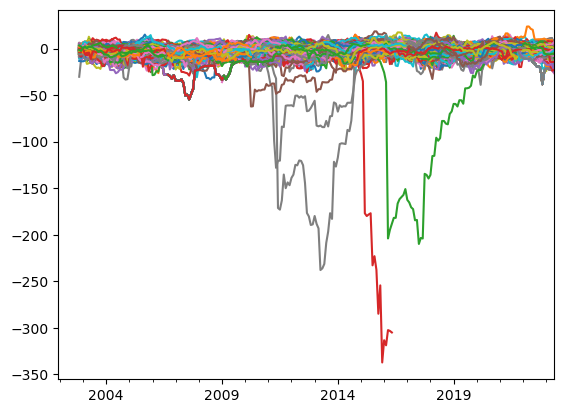

In [83]:
for x in resid_standard[0:50]:
    resid_standard[x].plot()

# Momentum Port vs Residual

### (t-1, t-12)
### Time : '2001-01-01'

In [84]:
'''투자날짜'''
pnl_start_date = '2000-01-01'

'''t-1 ~ t-12, 하고, 롤링기간 사라진거 없애기'''
mom_1_ret = df_ret.shift(1).rolling(11).apply(lambda x: (1+x).prod()-1)
mom_1_ret = mom_1_ret.loc[pnl_start_date:]

In [85]:
def create_cumprod (pnl_df):
    
    return ((pnl_df+1).cumprod()-1).to_frame()

가치중립 포트폴리오

In [89]:
'''얘는 매달 수익률'''
monthly_ret = df_ret

pnl_ret_list  = []
ivst_idx_list = []
long_tick_list = []
short_tick_list = []
s_ret_list = []
l_ret_list = []

for num in mom_1_ret.iloc[:-1].index:
    series = mom_1_ret.loc[num].dropna()

    date_idx = series.name
    ivst_idx = monthly_ret.index[np.where(monthly_ret.index==date_idx)[0][0] + 1]

    long_tick = series[series > series.quantile(0.9)].index.to_list()
    short_tick = series[series < series.quantile(0.1)].index.to_list()
    #short_tick = series[series < series.quantile(0.2)].index.to_list()

    long_ret = monthly_ret.loc[ivst_idx, long_tick].mean()
    short_ret = monthly_ret.loc[ivst_idx, short_tick].mean()
    
    '''Equal Weight'''
    pnl_ret = monthly_ret.loc[ivst_idx, long_tick].mean() - monthly_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret_list.append(pnl_ret)
    ivst_idx_list.append(ivst_idx)
    long_tick_list.append(long_tick)
    short_tick_list.append(short_tick)
    s_ret_list.append(short_ret)
    l_ret_list.append(long_ret)
    

mom_1_pnl = pd.DataFrame(index=ivst_idx_list, \
                         data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                         columns=['mom_1_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

mom_1_pnl_cum = create_cumprod(mom_1_pnl.iloc[:,0])

<AxesSubplot:>

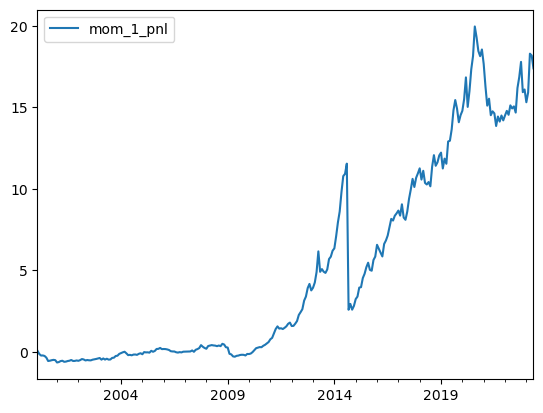

In [90]:
mom_1_pnl_cum.plot()

In [92]:
monthly_ret = df_ret
resid_mom_1_ret_list = []
resid_mom_1_ret_date_list = []
#top_resid_num = []

monthly_resid = resid_standard.iloc[np.where(resid_standard.sum(axis=1) != 0)].iloc[:-1]
monthly_ret = m_ret.iloc[:-1]

for sig_index in tqdm(monthly_resid.index[:-1]):
    
    '''시그널 날짜'''
    sig_index = sig_index
    
    '''투자 수익률 날짜'''
    invest_index = monthly_ret.index[np.where(monthly_ret.index == sig_index)[0] + 1][0]
    
    '''편의를 위해'''
    series = monthly_resid.loc[sig_index]
    '''종목 선정'''
    long_tick   = series[series>=series.quantile(0.9)].index
    short_tick  = series[series<=series.quantile(0.1)].index

    '''수익률 (eq weight)'''
    long_ret    = m_ret.loc[invest_index, long_tick].mean()
    short_ret   = m_ret.loc[invest_index, short_tick].mean()

    '''mom_port_ret'''
    mom_port_ret = long_ret - short_ret

    '''저장'''
    resid_mom_1_ret_date_list.append(invest_index)
    resid_mom_1_ret_list.append(mom_port_ret)

    '''이외 디버깅'''
    #top_resid_num.append(len(long_tick))

resid_mom_1_pnl = pd.DataFrame(index=resid_mom_1_ret_date_list, \
                         data=resid_mom_1_ret_list,\
                         columns=['resid_1_pnl'])

resid_mom_1_pnl_cum = create_cumprod(resid_mom_1_pnl.iloc[:,0])


100%|██████████| 245/245 [00:00<00:00, 557.37it/s]


In [ ]:
resid_mom_1_pnl.iloc

In [93]:
resid_mom_1_pnl_cum

,resid_1_pnl
2002-12-31,-0.114390
2003-01-31,-0.100783
2003-02-28,-0.114444
2003-03-31,-0.151542
2003-04-30,-0.102597
...,...
2022-12-31,20.044767
2023-01-31,21.105243
2023-02-28,21.995567
2023-03-31,23.408053


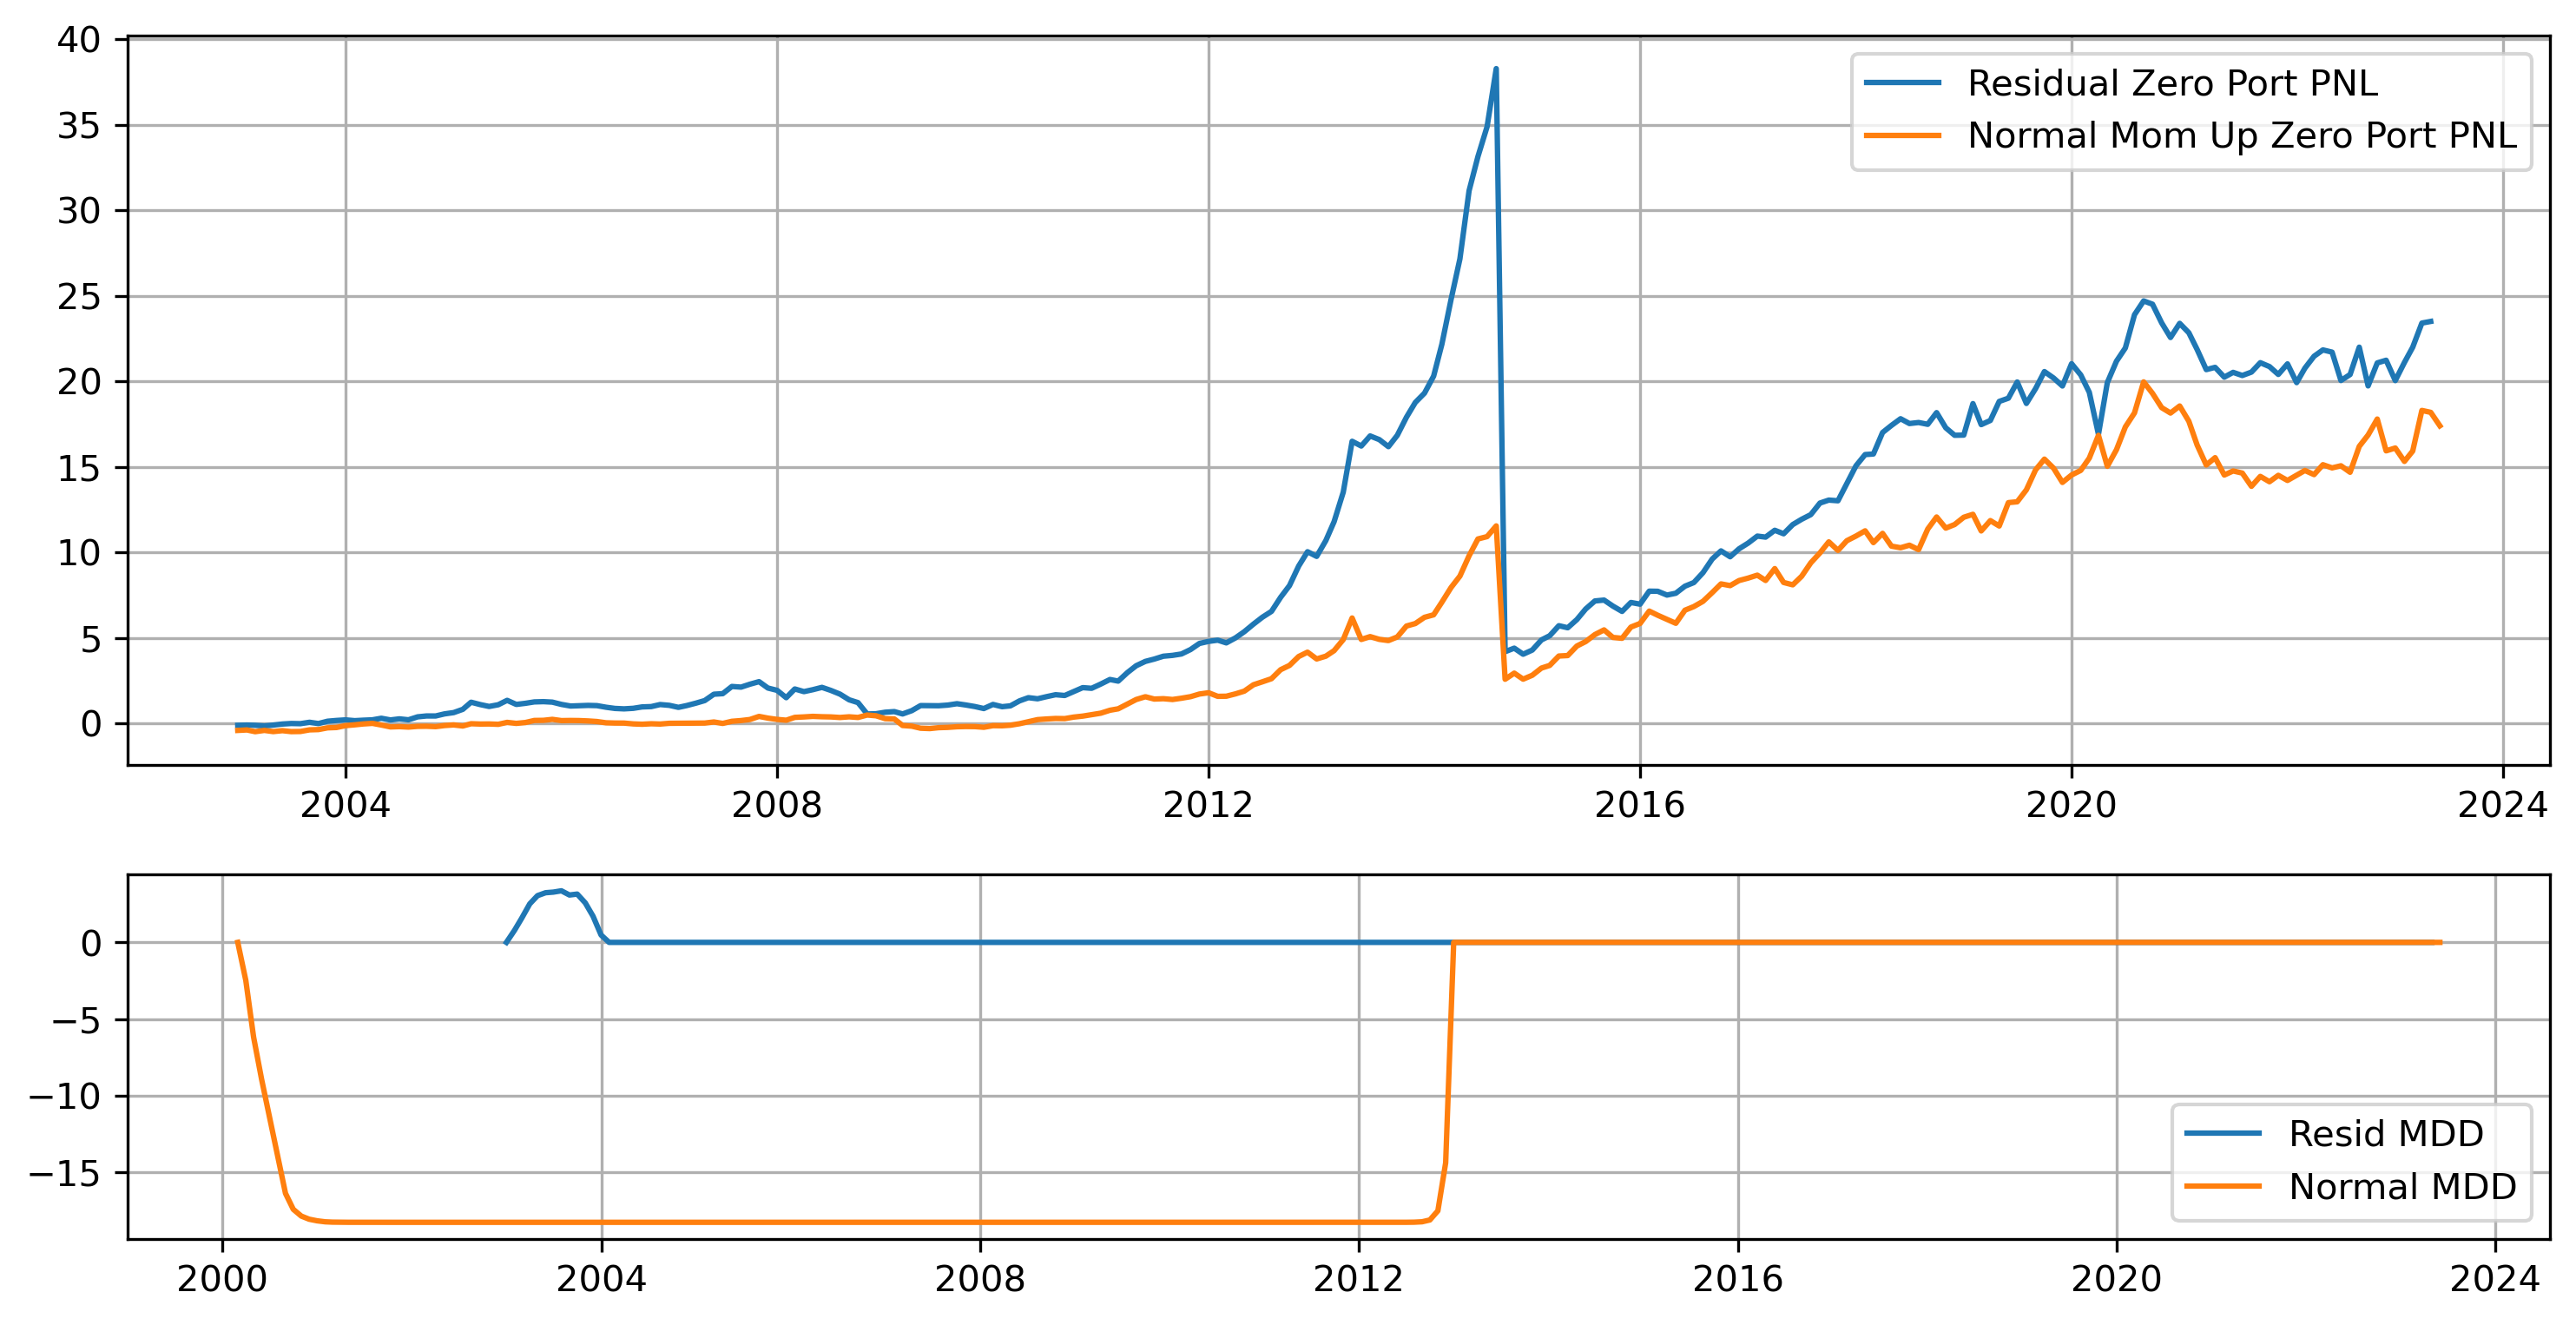

In [95]:
fig = plt.figure(figsize=(12,6), dpi=300)

spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[2, 1])

ax0 = fig.add_subplot(spec[0])
ax0.plot(resid_mom_1_pnl_cum, label='Residual Zero Port PNL')
ax0.plot(mom_1_pnl_cum.loc[resid_mom_1_pnl_cum.index[0]:], label='Normal Mom Up Zero Port PNL')
ax0.grid()
ax0.legend()

ax1 = fig.add_subplot(spec[1])
ax1.plot(cal_mdd(resid_mom_1_pnl_cum), label='Resid MDD')
ax1.plot(cal_mdd(mom_1_pnl_cum), label='Normal MDD')
ax1.legend()
ax1.grid()

fig.show()
